In [1]:
# 虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。
# 与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。
# 研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式

In [ ]:
# 经典卷积神经网络的基本组成部分是下面的这个序列：
# 1.带填充保持分辨率的Conv
# 2.非线性激活函数
# 3.汇聚层，如MaxPooling

In [2]:
# 而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。
# 下面的代码中，我们定义了一个名为vgg_block的函数来实现一个VGG块。

import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                               kernel_size = 3, padding = 1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [3]:
# 与AlexNet、LeNet一样，VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。
# Vgg 由几个这样的 block 组成，最后接三个全连接密集块

# 原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 
# 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。
# 由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11

##### 下面的代码实现了VGG-11。可以通过在conv_arch上执行for循环来简单实现

In [8]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接密集层
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(p = 0.5), # 这里默认了conv后变成 7*7
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p = 0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [11]:
X = torch.rand(size = (1, 1, 224, 224))
for layers in net:
    X = layers(X)
    print(layers.__class__.__name__, 'shape is: \t', X.shape)

Sequential shape is: 	 torch.Size([1, 64, 112, 112])
Sequential shape is: 	 torch.Size([1, 128, 56, 56])
Sequential shape is: 	 torch.Size([1, 256, 28, 28])
Sequential shape is: 	 torch.Size([1, 512, 14, 14])
Sequential shape is: 	 torch.Size([1, 512, 7, 7])
Flatten shape is: 	 torch.Size([1, 25088])
Linear shape is: 	 torch.Size([1, 4096])
ReLU shape is: 	 torch.Size([1, 4096])
Dropout shape is: 	 torch.Size([1, 4096])
Linear shape is: 	 torch.Size([1, 4096])
ReLU shape is: 	 torch.Size([1, 4096])
Dropout shape is: 	 torch.Size([1, 4096])
Linear shape is: 	 torch.Size([1, 10])


In [13]:
# 缩小一点outchannels

ratio = 4
s_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch] # o_channel缩小版
net = vgg(s_conv_arch)

loss 0.178, train acc 0.934, test acc 0.914
1145.6 examples/sec on cuda:0


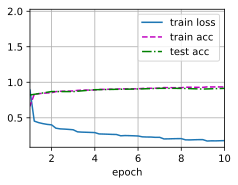

In [14]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [16]:
# 简要总结一下
# Vgg的特点是通过块组成的网络
# 1.自定义的块，把自定义的块解包放进layer: *conv_blks
# 2.我们实现的vgg11，包括了五个块+三个全连接密集块
# 3. 11的名字由来：1+1+2+2+2 + 3（MLP）

# vgg 确立了一种结构范式 
# 1.用两个33替换一个5的卷积，参数从25变18，感受野不变
# 2.创立了块，结构化，标准化
# 3.非线性更强，一个5只有一个Relu,两个3有2个Relu

##### 下一章我们将会跳过NiN网络。 NiN网络引入了块、 1*1 卷积，以及取消全连接层，使用了平均汇聚层分类。
##### 但是 NiN 没有足够的创新之处和网络结构